# SHACL Simple

SHACL validation examples

It should be noted here that SHACL validation is not a service OIH offers.  Rather, 
the validation is a capacity that the OIH architectural approach facilities.  Further
this validation follows W3C recommendations as describted in 
[https://www.w3.org/TR/shacl/](https://www.w3.org/TR/shacl/).

* [SHACL Playground](https://shacl.org/playground/)
* [pySHACL](https://github.com/rdflib/pyshacl)
* [kglab SHACL validation with pySHACL](https://derwen.ai/docs/kgl/ex5_0/)


## Imports

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)  ## remove pandas future warning

from urllib.request import urlopen
import kglab
from rdflib import Graph, plugin
from rdflib.serializer import Serializer
import pandas as pd
import seaborn as sns
from rdflib import Graph  #, plugin
import matplotlib.pyplot as plt
import boto3

# pyshack sends output to log along with the vars.  This suppresses that
import logging, sys
logging.disable(sys.maxsize)

import time, io
from datetime import datetime
from reportlab.lib.enums import TA_JUSTIFY
from reportlab.lib.pagesizes import letter
from reportlab.platypus import *
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.rl_config import defaultPageSize
from reportlab.lib.units import inch
from reportlab.platypus.tables import Table
from reportlab.platypus import SimpleDocTemplate



## Graphs

There are two graphs involved in each action, the data and shape graph.  The "data graph" which will be the graph we are testing and the "shape graph" which is the graph containing our validation and constraint logic.  Both of these are RDF based but can be in any serialization.  

Here we have used JSON-LD for the data graph, since that is what people are using to publish structured data on the web at their web sites, so lets stick with that.

For the shape graph, we use Turtle (.ttl) because it's cleaner, compact and a bit more friendly for human reading.  Since this graph is being built by humans for computers, lets cater to the human in that equation.

In [2]:
namespaces = {
    "shacl":   "http://www.w3.org/ns/shacl#" ,
    }

kg = kglab.KnowledgeGraph(
    name = "Schema.org based datagraph",
    base_uri = "https://example.org/id/",
    namespaces = namespaces,
    )

In [18]:
# Paramters (set up for pagemill)
# dg = [ "./datagraphs/full.jsonld"]  # "./datagraphs/full.jsonld",
# sg = './shapes/soso_common_v1.2.3.ttl'
# dg = ["https://raw.githubusercontent.com/geoschemas-org/geoshapes/master/datagraphs/dataset-full-BAD.json-ld"]
dgurl = "http://ossapi.oceaninfohub.org/public/graphs/summonededmo_2023-02-21-06-26-50_release.rdf"
sgurl =  "https://raw.githubusercontent.com/iodepo/odis-arch/schema-dev-df/code/notebooks/validation/shapes/oih_search.ttl"
# sgurl = "https://raw.githubusercontent.com/ESIPFed/science-on-schema.org/226-esip-summer-mtg-2022-tutorial/tutorials/esip-summer-mtg-2022/ShapeGraphs/sosoShapeNoProtoCheck.ttl"
now = datetime.now()
date_time = now.strftime("%m-%d-%Y-%H-%M-%S")
# runid = str("GleanerValidation_{}".format(date_time))

In [19]:
sf = urlopen(sgurl)
sg = sf.read()


In [20]:
df = urlopen(dgurl)
dg = df.read()

In [21]:
fna = []   # array to hold errors
try:
    g = Graph().parse(dg, format='n3')
    result = g.serialize(format='ttl')# .decode('utf-8')
    kg.load_rdf_text(result)
except:
    print("An exception occurred with {}".format(fn))
    fna.append(fn)

conforms, report_graph, report_text = kg.validate(
    shacl_graph=sg,
    shacl_graph_format="ttl"
)

# print(report_text)
# print(fna)

kg.load_rdf_text(data=report_graph.save_rdf_text(), format="ttl")

Checking 14712048 object(s)
severity                          shacl:Violation  shacl:Warning
message                                                         
Headline is suggested                           0           4723
Resource must have a description             1166              0


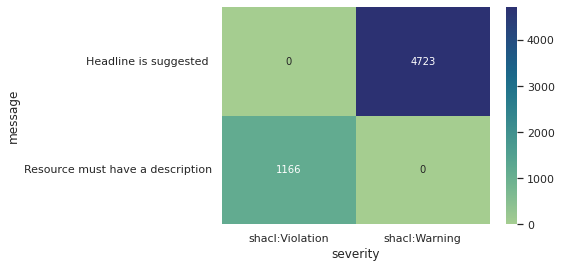

In [22]:
# SELECT  ?severity  ?constraint ?path ?message ?focus ?path ?value ?id

sparql = """
SELECT  ?severity  ?constraint ?path ?message ?focus ?path ?value
  WHERE {
    ?id rdf:type shacl:ValidationResult .
    ?id shacl:focusNode ?focus .
    ?id shacl:resultMessage ?message .
    ?id shacl:resultSeverity ?severity .
    ?id shacl:sourceConstraintComponent ?constraint .
    OPTIONAL {
        ?id shacl:resultPath ?path .
    }
    OPTIONAL {
        ?id shacl:value ?value .
    }
  }
"""

pdf = kg.query_as_df(sparql)
df = pdf  #.to_pandas()  #  including .to_pandas() breaks with papermill for reasons unknown at this time if to_pandas() is used, needed in my kglab conda env

if 'severity' in df.columns:
    dfc = df.groupby('severity').count().reset_index().rename(columns={'path': 'Count'})
    ctst = pd.crosstab(df['message'], df['severity'],  margins = False , margins_name = 'Totals')

    s1 = str("Checking {} object(s)".format(len(dg) ))
    print(s1)
    print(ctst)

    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.heatmap(ctst, annot=True, fmt=".0f", cmap = sns.cm.crest)
    plt.savefig('./output/heatmap_{}.png'.format(date_time))
else:
    print("No severity column found, all SHACL validations must have passed OR a processing error occurred upstream")


In [27]:
# build report

#set up a stream
stream = io.BytesIO()

Story=[]

styles = getSampleStyleSheet()
HeaderStyle = styles["Heading1"]
ParaStyle = styles["Normal"]
PreStyle = styles["Code"]

def header(txt, style=HeaderStyle, klass=Paragraph, sep=0.3):
    s = Spacer(0.2*inch, sep*inch)
    para = klass(txt, style)
    sect = [s, para]
    result = KeepTogether(sect)
    return result

def pre(txt):
    s = Spacer(0.1*inch, 0.1*inch)
    p = Preformatted(txt, PreStyle)
    precomps = [s,p]
    result = KeepTogether(precomps)
    return result

#  use for a file
doc = SimpleDocTemplate("./output/report_{}.pdf".format(date_time),pagesize=letter,  
                        rightMargin=72,leftMargin=72,
                        topMargin=72,bottomMargin=18)

# use for object
# doc = SimpleDocTemplate(stream,pagesize=letter,
#                         rightMargin=72,leftMargin=72,
#                         topMargin=72,bottomMargin=18)

logo = './output/heatmap_{}.png'.format(date_time)
im = Image(logo, 4*inch, 3*inch)

address_parts = ["RunID: {}".format(date_time), "Shape graph: {}".format(sgurl)]

styles=getSampleStyleSheet()
styles.add(ParagraphStyle(name='Justify', alignment=TA_JUSTIFY))



# Create return address
full_name = "Validation report"
ptext = '%s' % full_name
Story.append(Paragraph(ptext, styles["Heading1"]))

# add date and time
formatted_time = time.ctime()
ptext = '%s' % formatted_time
Story.append(Paragraph(ptext, styles["Normal"]))
Story.append(Spacer(1, 12))

for part in address_parts:
    ptext = '%s' % part.strip()
    Story.append(Paragraph(ptext, styles["Normal"]))

Story.append(Spacer(1, 12))
ptext = 'There were validation issues with the following resources.  They were not able to be checked'
Story.append(Paragraph(ptext, styles["Justify"]))
Story.append(Spacer(1, 12))
for part in fna:
    ptext = '%s' % part.strip()
    Story.append(Paragraph(ptext, styles["Code"]))

Story.append(Spacer(1, 12))

ptext = 'This is a validation report using pySHACL to process the provided data graphs \
        against the noted shape graph.  A heat map of the results is seen below to provide \
        a quick over view.  However, the details are easier to leverage from the generated \
        CSV document that will come with this report. '

Story.append(Paragraph(ptext, styles["Justify"]))
Story.append(Spacer(1, 12))

Story.append(Paragraph(s1, styles["Justify"]))
Story.append(Spacer(1, 12))

# Story.append(Paragraph(str(ctst), styles["Code"]))
# Story.append(Spacer(1, 12))

# Add the image
Story.append(im)

ptext = 'For more information about validation please visit the project documentation.  \
        Details of the errors reported can be found in the shape file documentation page.'
Story.append(Paragraph(ptext, styles["Justify"]))

# Create return address
Story.append(Spacer(1, 12))
full_name = "Details"
ptext = '%s' % full_name
Story.append(Paragraph(ptext, styles["Heading1"]))

ptext = 'Details of the detected violations and the associated reference node are found in the CSV \
        that accompany this report:  validationReport_{}.csv '.format(date_time)

Story.append(Paragraph(ptext, styles["Justify"]))

# add table
# rlab_table_data=[['Index','Path','Constraint','Severity','Message','ID', 'Focus]]+df.values.tolist()

# this is the table of the data fram, but useless in this PDF, just save to CSV and send that. 
# table = Table(df.values.tolist(), colWidths=150, rowHeights=20, splitByRow=1)
# Story.append(Spacer(1, 12))
# Story.append(table)

doc.build(Story)

In [24]:
# write to S3
# get buffer

stream.seek(0)  # rewind the buffer

pdf_buffer = stream.getbuffer()

filename = "new.pdf"
bucket_name = 'insert_bucket_name'
object_name = bucket_name

# Method 1: Object.put()
s3 = boto3.resource('s3')
object = s3.Object('my_bucket_name', 'my/key/including/filename.txt')
object.put(Body=stream.getvalue())

# Method 2: Client.put_object()
client = boto3.client('s3')
client.put_object(Body=stream.getvalue(), Bucket='my_bucket_name', Key='my/key/including/anotherfilename.txt')


NoSuchBucket: An error occurred (NoSuchBucket) when calling the PutObject operation: The specified bucket does not exist

In [28]:
df.to_csv("./output/validationReport_{}.csv".format(date_time))

## Write to S3

convert the above to use stream buffer like in https://groups.google.com/g/django-users/c/Towha5_okco/m/mxFsycoHDQAJ?pli=1

```python
from io import StringIO # python3; python2: BytesIO 
import boto3

bucket = 'my_bucket_name' # already created on S3
csv_buffer = StringIO()
df.to_csv(csv_buffer)
s3_resource = boto3.resource('s3')
s3_resource.Object(bucket, 'df.csv').put(Body=csv_buffer.getvalue())
```